In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.utils import plot_model

2024-04-03 13:24:33.097741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 13:24:33.097851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 13:24:33.276250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Function to load data
def load_data(data_dir, target_names):
    img_arr = []
    img_label = []
    label_to_text = {}
    label = 0

    for dir_ in os.listdir(data_dir):
        if dir_ in target_names:
            for f in os.listdir(data_dir + dir_ + "/"):
                img = cv2.imread(data_dir + dir_ + "/" + f)
                img = cv2.resize(img, (75, 75))

                # Convert image to RGB format if it's grayscale
                if img.shape[-1] == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                img_arr.append(img)
                img_label.append(label)
            print(f"loaded {dir_} images to numpy arrays...")
            label_to_text[label] = dir_
            label += 1

    img_arr = np.array(img_arr)
    img_label = np.array(img_label)
    img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

    return img_arr, img_label, label_to_text

In [ ]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load training data
data_dir_train = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/train/"
img_arr_train, img_label_train, label_to_text_train = load_data(data_dir_train, target_names)

# Load test data
data_dir_test = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/test/"
img_arr_test, img_label_test, label_to_text_test = load_data(data_dir_test, target_names)

INPUT_SHAPE = (75, 75, 3)
NUM_CLASSES = len(target_names)
BATCH_SIZE = 32
EPOCHS = 100

img_arr_train.shape, img_label_train.shape, label_to_text_train
img_arr_test.shape, img_label_test.shape, label_to_text_test

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((3068, 75, 75, 3),
 (3068, 7),
 {0: 'surprise',
  1: 'fear',
  2: 'angry',
  3: 'neutral',
  4: 'sad',
  5: 'disgust',
  6: 'happy'})

In [ ]:
total_images_train = 0
for dir_ in os.listdir(data_dir_train):
    if dir_ in target_names:
        count = 0
        for f in os.listdir(data_dir_train + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of training images")
        total_images_train += count

print(f"\ntotal training images are {total_images_train}\n")

surprise has 1290 number of training images
fear has 281 number of training images
angry has 705 number of training images
neutral has 2524 number of training images
sad has 1982 number of training images
disgust has 717 number of training images
happy has 4772 number of training images

total training images are 12271



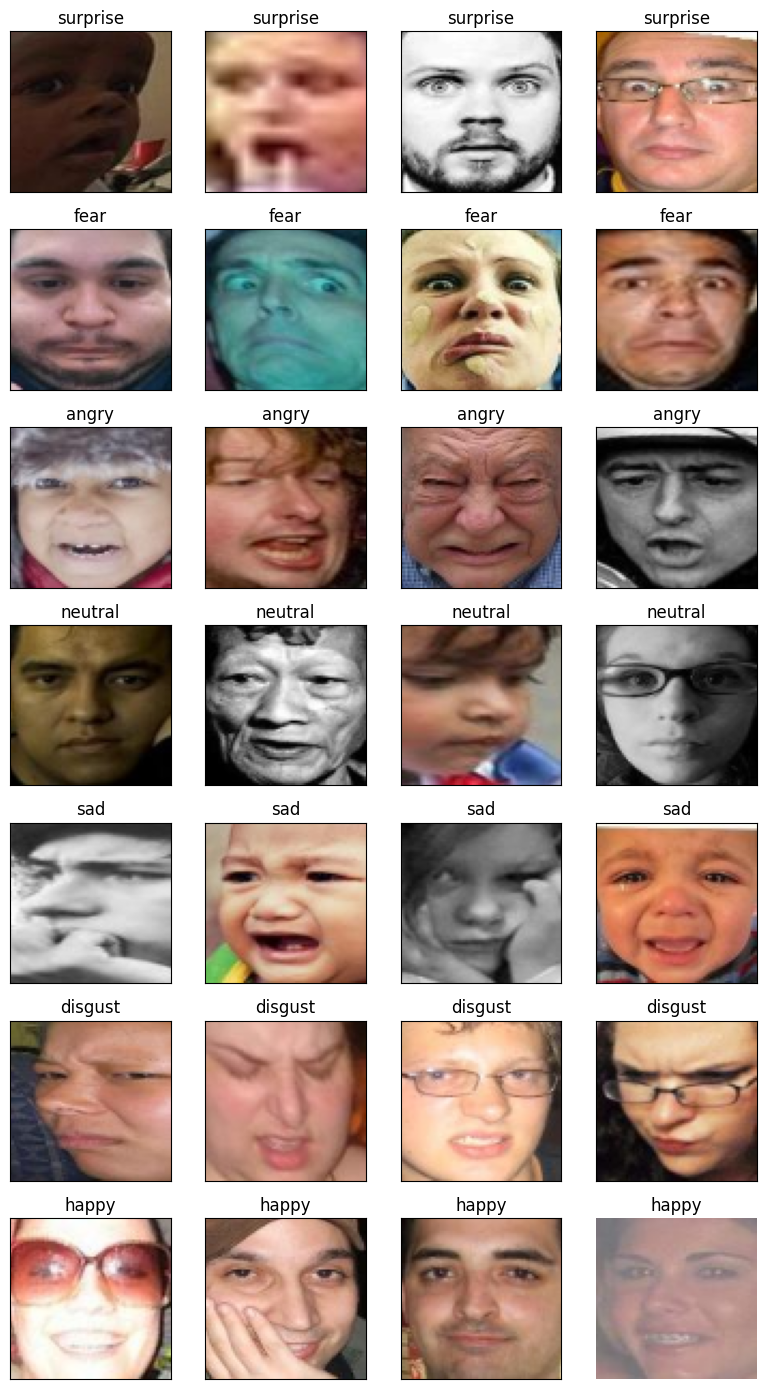

In [ ]:
num_emotions = len(target_names)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text_train:
    sample_indices = np.random.choice(np.where(img_label_train[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr_train[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img), plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text_train[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

# Fit the data generator on training data
train_datagen.fit(img_arr_train)

In [ ]:
# Load the Xception model
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model architecture on top of pre-trained model
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
custom_early_stopping = CustomEarlyStopping(patience=25)

# Train the top layer
history_top_layer = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=BATCH_SIZE),
    validation_data=(img_arr_test, img_label_test),
    steps_per_epoch=int(len(img_arr_train) / BATCH_SIZE),
    epochs = EPOCHS,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/383 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.1979 - loss: 17.5674 

I0000 00:00:1712150831.735895      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712150831.772348      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/383 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - accuracy: 0.2676 - loss: 14.0864

W0000 00:00:1712150838.220655      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3101 - loss: 5.2432

W0000 00:00:1712150858.568172      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.3102 - loss: 5.2369 - val_accuracy: 0.3960 - val_loss: 1.6484 - learning_rate: 0.0010
Epoch 2/100
  1/383 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2812 - loss: 1.7713

W0000 00:00:1712150864.474444      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2812 - loss: 1.7713 - val_accuracy: 0.3950 - val_loss: 1.6855 - learning_rate: 0.0010
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.3962 - loss: 1.7112 - val_accuracy: 0.4296 - val_loss: 1.6034 - learning_rate: 0.0010
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.2277 - val_accuracy: 0.4316 - val_loss: 1.5846 - learning_rate: 0.0010
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.4069 - loss: 1.6289 - val_accuracy: 0.4404 - val_loss: 1.5267 - learning_rate: 0.0010
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5625 - loss: 1.2623 - val_accuracy: 0.4371 - val_loss: 1.5262 - learning_rate: 0.0010
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.4142 - loss: 1.6012 - val_accuracy: 0.4306 - val_loss: 1.5404 - learning_rate: 0.0010
Epoch 8/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4688 - loss: 1.4516 -

In [ ]:
# Create history dataframe for the top layer training
history_top_layer_df = pd.DataFrame(history_top_layer.history)
history_top_layer_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.340714,2.824500,0.396023,1.648422,1.000000e-03
1,0.281250,1.771278,0.395046,1.685521,1.000000e-03
2,0.396519,1.696659,0.429596,1.603365,1.000000e-03
3,0.593750,1.227699,0.431551,1.584632,1.000000e-03
4,0.411962,1.608215,0.440352,1.526735,1.000000e-03
5,0.562500,1.262276,0.437093,1.526179,1.000000e-03
6,0.415884,1.586379,0.430574,1.540412,1.000000e-03
7,0.468750,1.451573,0.425359,1.555566,1.000000e-03
8,0.424136,1.571208,0.422751,1.566621,1.000000e-03
9,0.562500,1.230715,0.423077,1.565313,1.000000e-04


In [ ]:
# Fine-tuning the entire model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model after fine-tuning
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 21,070,127 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# Train the entire model end-to-end with a low learning rate
history_fine_tuning = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=BATCH_SIZE),
    validation_data=(img_arr_test, img_label_test),
    steps_per_epoch=int(len(img_arr_train) / BATCH_SIZE),
    epochs = EPOCHS,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/383 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.2266 - loss: 1.8571   

W0000 00:00:1712151412.007453      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/383 ━━━━━━━━━━━━━━━━━━━━ 1:33 313ms/step - accuracy: 0.2167 - loss: 1.8473

W0000 00:00:1712151438.204778      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2786 - loss: 1.8306

W0000 00:00:1712151463.165591      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 99s 142ms/step - accuracy: 0.2788 - loss: 1.8305 - val_accuracy: 0.4048 - val_loss: 1.6487 - learning_rate: 1.0000e-05
Epoch 2/100
  1/383 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.4062 - loss: 1.6947

W0000 00:00:1712151466.405096      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4062 - loss: 1.6947 - val_accuracy: 0.4051 - val_loss: 1.6470 - learning_rate: 1.0000e-05
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.4212 - loss: 1.6176 - val_accuracy: 0.4749 - val_loss: 1.4669 - learning_rate: 1.0000e-05
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4062 - loss: 1.3589 - val_accuracy: 0.4759 - val_loss: 1.4610 - learning_rate: 1.0000e-05
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.4774 - loss: 1.3809 - val_accuracy: 0.5430 - val_loss: 1.3591 - learning_rate: 1.0000e-05
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5938 - loss: 1.2141 - val_accuracy: 0.5430 - val_loss: 1.3586 - learning_rate: 1.0000e-05
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5338 - loss: 1.2451 - val_accuracy: 0.5883 - val_loss: 1.1914 - learning_rate: 1.0000e-05
Epoch 8/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy:

In [ ]:
# Create history dataframe for fine-tuning
history_fine_tuning_df = pd.DataFrame(history_fine_tuning.history)
history_fine_tuning_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.339897,1.799506,0.404824,1.648677,1.000000e-05
1,0.406250,1.694666,0.405150,1.646964,1.000000e-05
2,0.435166,1.536725,0.474902,1.466913,1.000000e-05
3,0.406250,1.358896,0.475880,1.461011,1.000000e-05
4,0.496364,1.336295,0.543025,1.359058,1.000000e-05
...,...,...,...,...,...
59,0.781250,0.515588,0.744785,0.773586,1.000000e-07
60,0.832584,0.467659,0.745437,0.766570,1.000000e-07
61,0.781250,0.555098,0.744785,0.767443,1.000000e-07
62,0.838794,0.465270,0.743807,0.766956,1.000000e-07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

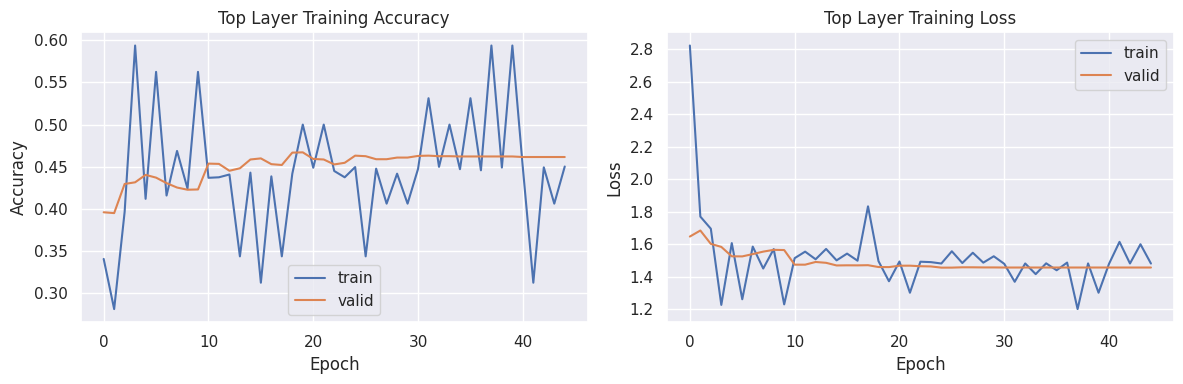

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

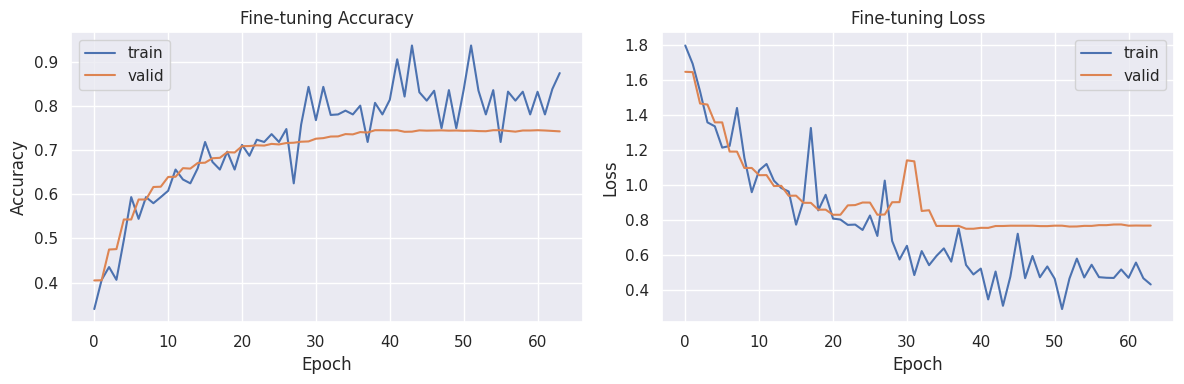

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training history for the top layer training
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['accuracy'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_accuracy'], label='valid')
plt.title('Top Layer Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['loss'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_loss'], label='valid')
plt.title('Top Layer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

# Visualize training history for fine-tuning
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['accuracy'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_accuracy'], label='valid')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['loss'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_loss'], label='valid')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

384/384 - 9s - 22ms/step - accuracy: 0.8692 - loss: 1.4289


W0000 00:00:1712152461.722771      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.8692038059234619
96/96 - 2s - 18ms/step - accuracy: 0.7454 - loss: 0.7490

Test Accuracy: 0.7454367876052856
 7/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

W0000 00:00:1712152466.510705      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


W0000 00:00:1712152470.860406      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Classification Report:
               precision    recall  f1-score   support

       angry       0.73      0.68      0.70       329
     disgust       0.69      0.36      0.48        74
        fear       0.59      0.63      0.61       162
       happy       0.66      0.76      0.71       680
     neutral       0.67      0.68      0.68       478
         sad       0.43      0.26      0.32       160
    surprise       0.88      0.88      0.88      1185

    accuracy                           0.75      3068
   macro avg       0.67      0.61      0.63      3068
weighted avg       0.74      0.75      0.74      3068



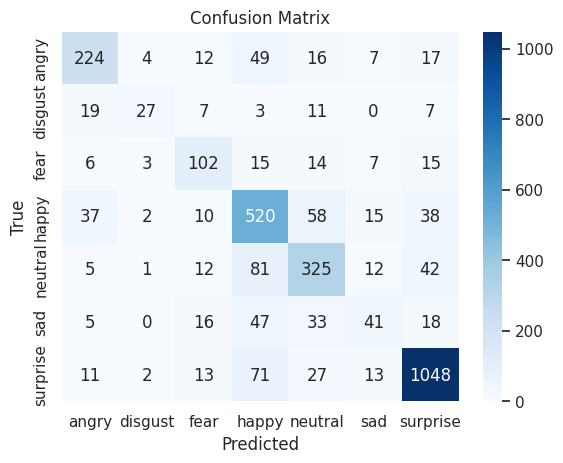

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(img_arr_train, img_label_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(img_arr_test, img_label_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(img_arr_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(img_label_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

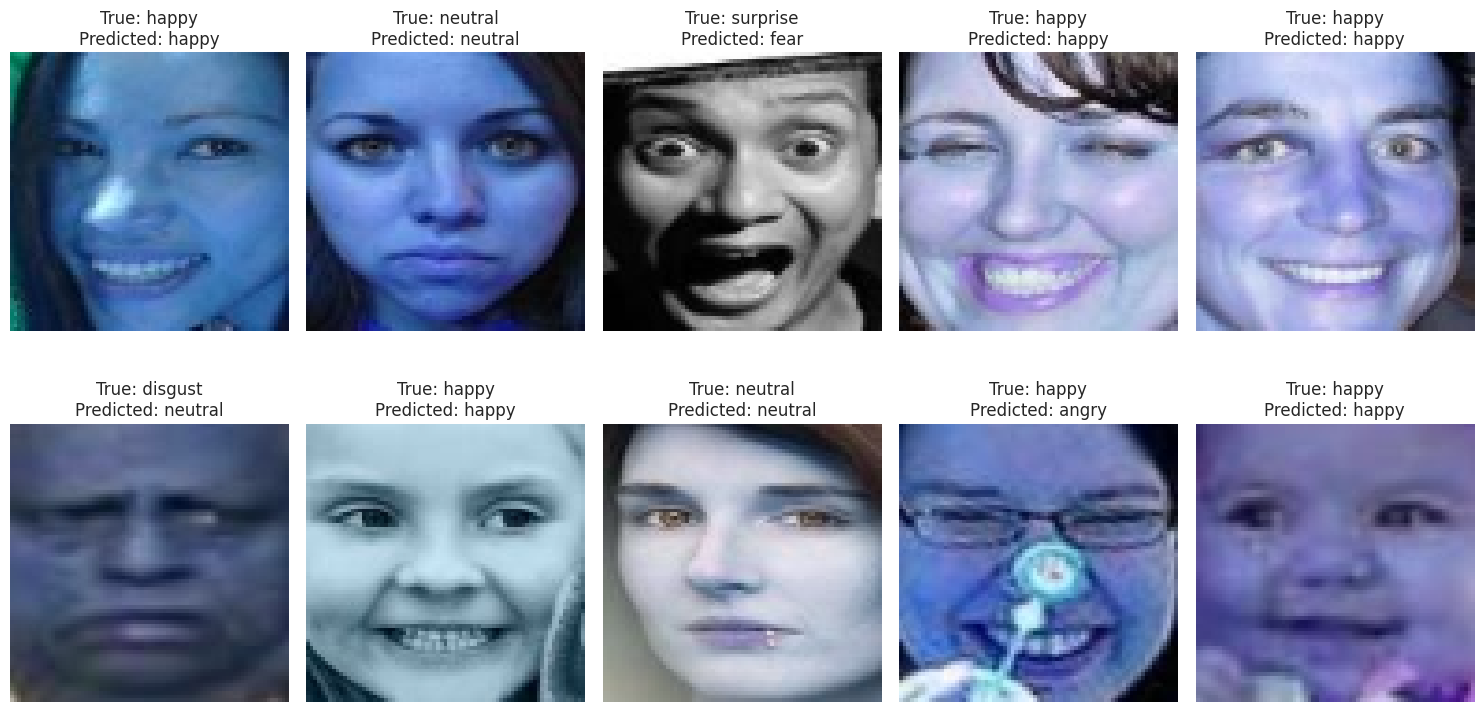

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(img_arr_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_arr_test[idx])
    plt.title(f"True: {label_to_text_test[true_labels[idx]]}\nPredicted: {label_to_text_test[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()